In [4]:
from glob import glob
import json
import pandas as pd
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import numpy as np
import concurrent.futures
import random
import gc

In [5]:
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

In [9]:
arquivos = glob('data/justica_trabalho/*/*.json')
arquivos += glob('data/justica_estadual/*/*.json')
arquivos += glob('data/justica_federal/*/*.json')

In [10]:
classes = pd.read_csv('data/sgt_classes.csv', sep=';')

In [11]:
criminal = [i for i in classes.descricao.values if 'crimin' in i.lower()]
criminal += [i for i in classes.descricao.values if 'penal' in i.lower()]
criminal += [i for i in classes.descricao.values if 'pris' in i.lower()]
criminal += [i for i in classes.descricao.values if 'circuns' in i.lower()]
criminal += [i for i in classes.descricao.values if 'pena' in i.lower()]
criminal += [i for i in classes.descricao.values if 'crime' in i.lower()]
criminal += [i for i in classes.descricao.values if 'policia' in i.lower()]
len(criminal), criminal


(104,
 ['Discriminatória',
  'PROCESSO CRIMINAL',
  'Representação Criminal',
  'Representação Criminal/Notícia de Crime',
  'Pedido de Arquivamento em Representação Criminal',
  'Restauração de Autos Criminal',
  'Procedimento do Juizado Especial Criminal - Sumariíssimo',
  'Habeas Corpus Criminal',
  'Pedido de Busca e Apreensão Criminal',
  'Medidas Investigatórias Sobre Organizações Criminosas',
  'Embargos de Terceiro Criminal',
  'Carta de Ordem Criminal',
  'Carta Precatória Criminal',
  'Carta Rogatória Criminal',
  'Apelação Criminal',
  'Correição Parcial Criminal',
  'Embargos de Declaração Criminal',
  'Recurso de Medida Cautelar Criminal',
  'Recurso de Sentença Criminal',
  'Remessa Necessária Criminal',
  'Revisão Criminal',
  'Incidente de Arguição de Inconstitucionalidade Criminal',
  'Medidas Protetivas de urgência (Lei Maria da Penha) Criminal',
  'Recurso Criminal',
  'Revisão Criminal',
  'Apelação Criminal',
  'Revisão Criminal',
  'Mandado de Segurança Criminal',

In [12]:
misc = [i for i in classes.descricao.values if 'alv' in i.lower()]

In [13]:
fiscal = [i for i in classes.descricao.values if 'fiscal' in i.lower()]
fiscal.remove('Organização e Fiscalização de Fundação')
fiscal

['Cautelar Fiscal',
 'Embargos Infringentes na Execução Fiscal',
 'Execução Fiscal',
 'Embargos à Execução Fiscal']

In [14]:
remover = criminal + fiscal + misc
EXCLUIR = classes[classes.descricao.isin(remover)].codigo.values.tolist()
EXCLUIR += [283, 1116, 994, 159, 197, 282, 172, 300 ]
EXCLUIR = list(set(EXCLUIR))
EXCLUIR[:5]

[1033, 11788, 11791, 11793, 11798]

In [15]:
def ano2(n_processo):
    if len(str(n_processo)) == 20:
        return int(str(n_processo)[9:13])
    else:
        print(n_processo)
        
def ano_ok(row):
    ano_ajuizamento = int(row.ano_ajuizamento)
    ano_numero = int(row.ano_numero)
    if ano_ajuizamento == ano_numero:
        return ano_ajuizamento
    lista_anos = [int(ano_ajuizamento), int(ano_numero)]
    lista_anos = [i for i in lista_anos if i > 1990]
    lista_anos = [i for i in lista_anos if i < 2021]
    if len(lista_anos) == 1:
        return lista_anos[0]
    elif len(lista_anos) == 0:
        return -1
    else:
        return max(lista_anos)

In [16]:
def get_clean_dataframes(arquivo):
    try:
        with open(arquivo) as f:
            data = json.load(f)
        df = pd.json_normalize(data)
        #print(df.shape)
        df.drop('millisInsercao', axis=1, inplace=True)
        df['ano_ajuizamento'] = df['dadosBasicos.dataAjuizamento'].apply(lambda x: str(x)[:4])
        df['ano_numero'] = df['dadosBasicos.numero'].apply(ano2)
        df['ano_ok'] = df.apply(ano_ok, axis=1)
        df = df[df['ano_ok'] >= 2010]
        df = df[~df['dadosBasicos.classeProcessual'].isin(EXCLUIR)]
        df = df[df.grau.isin(['G1', 'JE'])]
    except Exception as e:
        print(e, arquivo)
        return None
    gc.collect()
    return df

In [17]:
with concurrent.futures.ProcessPoolExecutor(max_workers=28) as fut:
     dataframes = list(tqdm(fut.map(get_clean_dataframes, arquivos), total=len(arquivos)))


In [18]:
print(len(dataframes))
dataframes = [i for i in dataframes if i is not None]
print(len(dataframes))

517
517


In [19]:
df = pd.concat(dataframes)

In [20]:
df.head()

,siglaTribunal,movimento,grau,dadosBasicos.valorCausa,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.nivelSigilo,dadosBasicos.classeProcessual,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,ano_ajuizamento,ano_numero,ano_ok,dadosBasicos.assunto.assuntoLocal.codigoAssunto,dadosBasicos.assunto.assuntoLocal.codigoPaiNacional,dadosBasicos.assunto.assuntoLocal.descricao,movimento.identificadorMovimento,movimento.xmlns,movimento.movimentoLocal.codigoMovimento,movimento.movimentoLocal.codigoPaiNacional,movimento.dataHora
0,TRT4,"[{'identificadorMovimento': '52034597', 'tipoR...",G1,35300.00,00202133320205040020,1.0,NaN,4314902,"[{'principal': True, 'assuntoLocal': None, 'co...",1,NaN,20200318002109,10.0,0,1125,20ª Porto Alegre,4314902,46964,ORIG,2020,2020,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRT4,"[{'identificadorMovimento': '52036527', 'tipoR...",G1,97000.00,00202875720205040030,1.0,NaN,4314902,"[{'principal': False, 'assuntoLocal': None, 'c...",1,NaN,20200318002308,8.0,0,985,30ª Porto Alegre,4314902,46974,ORIG,2020,2020,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRT4,"[{'identificadorMovimento': '52041238', 'tipoR...",G1,14244.46,00202360920205040204,1.0,NaN,4304606,"[{'principal': False, 'assuntoLocal': None, 'c...",1,NaN,20200318010510,5.0,0,985,4ª Canoas,4304606,46894,ORIG,2020,2020,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,TRT4,"[{'identificadorMovimento': '52041704', 'tipoR...",G1,10000.00,00201675020205040406,1.0,NaN,4305108,"[{'principal': True, 'codigoNacional': 9163}]",1,NaN,20200318081723,1.0,0,37,6ª Caxias do Sul,4305108,46902,ORIG,2020,2020,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,TRT4,"[{'identificadorMovimento': '52041887', 'tipoR...",G1,15000.00,00201019320205040851,1.0,NaN,4317103,"[{'principal': True, 'assuntoLocal': None, 'co...",1,NaN,20200318083036,2.0,0,193,VT Santana do Livramento,4317103,46985,ORIG,2020,2020,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.siglaTribunal.value_counts(normalize=True)

TRT11    0.030216
TJRO     0.025852
TRT16    0.024483
TJMG     0.024256
TJAM     0.023877
TRT8     0.022418
TRT15    0.022415
TRT7     0.022233
TRT10    0.021995
TRT14    0.021662
TRT12    0.020883
TRT18    0.020134
TRT6     0.020118
TJRN     0.020107
TRT2     0.020016
TJMT     0.019944
TRT4     0.019813
TJRS     0.019813
TRT5     0.019803
TRF5     0.019449
TJGO     0.019441
TRT1     0.019402
TJSC     0.019147
TRT17    0.019030
TJAP     0.018883
TJTO     0.018637
TJRR     0.018199
TRT3     0.018112
TRT21    0.018007
TRT13    0.017680
TJSE     0.017598
TJRJ     0.017585
TJDFT    0.017448
TJPI     0.017052
TRT24    0.017005
TJMS     0.016858
TJBA     0.016740
TRT22    0.016689
TJSP     0.016615
TJES     0.016434
TJPA     0.016349
TJPR     0.016193
TRT20    0.015089
TJMA     0.014799
TJPE     0.014780
TJPB     0.014661
TJCE     0.014049
TJAL     0.013967
TRT9     0.013515
TJAC     0.013498
TRF4     0.013098
TRT19    0.012658
TRF2     0.011423
TRF3     0.010467
TRF1     0.009400
TRT23    0

In [22]:
df.siglaTribunal = df.siglaTribunal.str.upper()

In [23]:
df.shape

(937621, 30)

In [24]:
movimentos = pd.read_csv('data/sgt_movimentos.csv', sep=';')

In [25]:
sentencas_1_grau = [
     'Procedência',
     'Improcedência',
     'Procedência em Parte',
     'Ausência de pressupostos processuais',
     'Inadmissibilidade do procedimento sumaríssimo',
     'Concessão de remissão a adolescente com exclusão do processo',
     'Procedência do pedido e procedência do pedido contraposto',
     'Procedência do pedido e procedência em parte do pedido contraposto',
     'Procedência do pedido e improcedência do pedido contraposto',
     'Procedência em parte do pedido e procedência do pedido contraposto',
     'Procedência em parte do pedido e procedência em parte do pedido contraposto',
     'Procedência em parte do pedido e improcedência do pedido contraposto',
     'Improcedência do pedido e procedência do pedido contraposto',
     'Improcedência do pedido e procedência em parte do pedido contraposto',
     'Improcedência do pedido e improcedência do pedido contraposto',
     'Procedência do Pedido - Reconhecimento pelo réu',
     'Pedido conhecido em parte e procedente',
     'Pedido conhecido em parte e procedente em parte',
     'Pedido conhecido em parte e improcedente',
     'Procedência',
     'procedência parcial',
     'improcedência',
     'Não conhecimento do pedido', 
    'Julgamento',
    'Homologado o Pedido',
    'Homologação de Transação'
]

codigos_sentencas= movimentos[movimentos.descricao.isin(sentencas_1_grau)].codigo.values.tolist()
len(codigos_sentencas)

26

In [26]:
def get_data_primeira_sentenca(lista_movimentos):
    if lista_movimentos in [None, np.nan]:
        return 'SEM MOVIMENTO', -1
    try:
        datas = [i['dataHora'] for i in lista_movimentos]
    except:
        print(lista_movimentos)
        raise
    lista_movimentos = sorted(lista_movimentos, key=lambda k: k['dataHora']) 
    for val in lista_movimentos:
        if 'movimentoNacional' in val.keys():
            if val['movimentoNacional'] is not None:
                if val['movimentoNacional']['codigoNacional'] in codigos_sentencas:
                        return val['dataHora'], val['movimentoNacional']['codigoNacional']
        if 'movimentoLocal' in val.keys():
            if val['movimentoLocal'] is not None:
                if val['movimentoLocal']['codigoPaiNacional'] in codigos_sentencas:
                    return val['dataHora'], val['movimentoLocal']['codigoPaiNacional']
    return 'SEM MOVIMENTO', -1

In [27]:
datas_sentenca = df.movimento.apply(get_data_primeira_sentenca)
df['data_primeira_sentenca'] = [i[0] for i in datas_sentenca.values]
df['codigo_primeira_sentenca'] = [i[1] for i in datas_sentenca.values]


In [28]:
df.reset_index(drop=True, inplace=True)

In [29]:
df[df.codigo_primeira_sentenca == -1].sample(5)

,siglaTribunal,movimento,grau,dadosBasicos.valorCausa,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.nivelSigilo,dadosBasicos.classeProcessual,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,ano_ajuizamento,ano_numero,ano_ok,dadosBasicos.assunto.assuntoLocal.codigoAssunto,dadosBasicos.assunto.assuntoLocal.codigoPaiNacional,dadosBasicos.assunto.assuntoLocal.descricao,movimento.identificadorMovimento,movimento.xmlns,movimento.movimentoLocal.codigoMovimento,movimento.movimentoLocal.codigoPaiNacional,movimento.dataHora,data_primeira_sentenca,codigo_primeira_sentenca
276428,TRT14,"[{'identificadorMovimento': '5066701', 'movime...",G1,5000.00,00006543820125140426,NaN,16,1200500,"[{'principal': False, 'codigoNacional': 1998},...",NaN,2.06827e+06,1355277600000,NaN,0,985,VARA DO TRABALHO DE SENA MADUREIRA/AC,1200500,30404,ORIG,1355,2012,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEM MOVIMENTO,-1
513135,TJGO,"[{'movimentoNacional': {'codigoNacional': 3}, ...",G1,NaN,02352624820108090067,NaN,NaN,1909,"[{'principal': True, 'codigoNacional': 8842}, ...",NaN,NaN,20100715000000,4.0,0,12154,"1ª Vara (Cível, Criminal - crime em geral e ex...",1909,52647,ORIG,2010,2010,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEM MOVIMENTO,-1
657791,TJRJ,"[{'tipoResponsavelMovimento': 0, 'movimentoNac...",G1,NaN,00008262720108190016,NaN,NaN,3301207,"[{'codigoAssunto': 30356, 'codigoPaiNacional':...",NaN,NaN,20100526000000,1.0,0,7,CARMO VARA UNICA,3301207,7977,ORIG,2010,2010,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEM MOVIMENTO,-1
31366,TRT11,"[{'identificadorMovimento': '7480799', 'movime...",G1,NaN,00003514720115110004,NaN,NaN,Manaus,"[{'principal': False, 'codigoNacional': 2641}]",NaN,NaN,1298343600000,NaN,0,985,4ª Vara do Trabalho de Manaus,1302603,27767,ORIG,1298,2011,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEM MOVIMENTO,-1
843281,TJRS,"[{'identificadorMovimento': '40', 'tipoRespons...",G1,3353.32,00203913320108210044,2.0,NaN,4306809,"[{'principal': True, 'codigoNacional': 7690}]",NaN,-1,20100309000000,1.0,0,169,2ª Vara - Encantado,4306809,3123,ORIG,2010,2010,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEM MOVIMENTO,-1


In [30]:
df[df.codigo_primeira_sentenca == -1].shape, df[df.codigo_primeira_sentenca != -1].shape

((622270, 32), (315351, 32))

In [31]:
df.shape

(937621, 32)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937621 entries, 0 to 937620
Data columns (total 32 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   siglaTribunal                                        937621 non-null  object 
 1   movimento                                            914278 non-null  object 
 2   grau                                                 937621 non-null  object 
 3   dadosBasicos.valorCausa                              602709 non-null  float64
 4   dadosBasicos.numero                                  937621 non-null  object 
 5   dadosBasicos.procEl                                  727492 non-null  float64
 6   dadosBasicos.competencia                             297382 non-null  object 
 7   dadosBasicos.codigoLocalidade                        937621 non-null  object 
 8   dadosBasicos.assunto                                 9

In [33]:
df.drop(['dadosBasicos.assunto.assuntoLocal.codigoAssunto', 'dadosBasicos.assunto.assuntoLocal.codigoPaiNacional',
'dadosBasicos.assunto.assuntoLocal.descricao', 'movimento.identificadorMovimento', 'movimento.xmlns', 
'movimento.movimentoLocal.codigoMovimento', 'movimento.movimentoLocal.codigoPaiNacional', 'movimento.dataHora'], axis=1, inplace=True)

In [34]:
def get_data_arquivamento(lista_movimentos):
    if lista_movimentos in [None, np.nan]:
        return 'SEM MOVIMENTO', -1
    try:
        datas = [i['dataHora'] for i in lista_movimentos]
    except:
        print(lista_movimentos)
        raise

    for val in lista_movimentos:
        if 'movimentoNacional' in val.keys():
            if val['movimentoNacional'] is not None:
                if val['movimentoNacional']['codigoNacional'] in codigos_arquivamento:
                        return val['dataHora'], val['movimentoNacional']['codigoNacional']
        if 'movimentoLocal' in val.keys():
            if val['movimentoLocal'] is not None:
                if val['movimentoLocal']['codigoPaiNacional'] in codigos_arquivamento:
                    return val['dataHora'], val['movimentoLocal']['codigoPaiNacional']
    return 'SEM MOVIMENTO', -1

In [35]:
arquivamento = [
'Baixa Definitiva',
'Arquivamento'
]
codigos_arquivamento= movimentos[movimentos.descricao.isin( arquivamento)].codigo.values.tolist()
codigos_arquivamento

[22, 228, 861, 12430]

In [36]:
data_arquivamento = df.movimento.apply(get_data_arquivamento)

In [37]:
data_arquivamento.sample(20)

811014      (SEM MOVIMENTO, -1)
287075      (SEM MOVIMENTO, -1)
935040    (20200630171247, 861)
597085      (SEM MOVIMENTO, -1)
9158        (SEM MOVIMENTO, -1)
481288      (SEM MOVIMENTO, -1)
76875       (SEM MOVIMENTO, -1)
899455     (20200702152825, 22)
318607      (SEM MOVIMENTO, -1)
433890      (SEM MOVIMENTO, -1)
119869      (SEM MOVIMENTO, -1)
601462      (SEM MOVIMENTO, -1)
739713      (SEM MOVIMENTO, -1)
584172      (SEM MOVIMENTO, -1)
674426      (SEM MOVIMENTO, -1)
646367      (SEM MOVIMENTO, -1)
113505      (SEM MOVIMENTO, -1)
160741      (SEM MOVIMENTO, -1)
317437      (SEM MOVIMENTO, -1)
407804      (SEM MOVIMENTO, -1)
Name: movimento, dtype: object

In [38]:
df['data_arquivamento'] = [i[0] for i in data_arquivamento.values]
df['codigo_arquivamento'] = [i[1] for i in data_arquivamento.values]

In [39]:
df[df.codigo_arquivamento == -1].shape, df[df.codigo_arquivamento != -1].shape

((824253, 26), (113368, 26))

In [40]:
def get_assunto_principal(lista_assuntos):
    if lista_assuntos in [None, np.nan]:
        return -1
    if type(lista_assuntos) == float:
        return -2
    try:
        assunto = [i for i in lista_assuntos if i['principal'] == True][0]
    except:
        assunto = lista_assuntos[0]
    try:
        if 'assuntoLocal' in assunto.keys():
            if assunto['assuntoLocal'] is not None:
                codigo = assunto['assuntoLocal']['codigoPaiNacional']
        if 'codigoNacional' in assunto.keys():
            codigo = assunto['codigoNacional']
        if 'codigoAssunto' in assunto.keys():
            if 'codigoPaiNacional' in assunto.keys():
                codigo = assunto['codigoPaiNacional']

            
        return codigo
    except:
        #print(lista_assuntos)
        #raise
        return -3


In [41]:
df['codigo_assunto_principal'] = df['dadosBasicos.assunto'].apply(get_assunto_principal)

In [42]:
df[df['codigo_assunto_principal'] < 0].codigo_assunto_principal.value_counts()

-2.0    4853
-3.0     182
Name: codigo_assunto_principal, dtype: int64

In [43]:
df['codigo_assunto_principal'].value_counts()[df['codigo_assunto_principal'].value_counts() > 100]

2641.0     61680
864.0      27642
1998.0     25053
2546.0     22853
9148.0     15346
           ...  
5933.0       103
10379.0      102
2477.0       102
10531.0      101
11848.0      101
Name: codigo_assunto_principal, Length: 585, dtype: int64

In [44]:
df['dadosBasicos.valorCausa'].notnull().sum(), df['dadosBasicos.valorCausa'].isnull().sum()

(602709, 334912)

In [45]:
def fix_data(fulldate):
    fulldate = str(fulldate)
    if fulldate[0] not in ['1', '2']:
        return np.nan
    ano = fulldate[:4]
    mes = fulldate[4:6]
    dia = fulldate[6:8]
    
    if int(mes)== 0 or int(mes) > 12:
        return np.nan
    if int(dia) == 0 or int(dia) > 31:
        return np.nan
    if int(ano) < 2000 or int(ano) > 2020:
        return np.nan
    else:
        return f'{ano}-{mes}-{dia}'

In [46]:
def get_data_primeiro_movimento(lista_movimentos):
    if lista_movimentos in [None, np.nan]:
        return np.nan
    try:
        lista_movimentos = [i for i in lista_movimentos if 'dataHora' in i.keys()]
        lista_movimentos = [i for i in lista_movimentos if i['dataHora'] != None]
        lista_movimentos = sorted(lista_movimentos, key=lambda k: k['dataHora']) 
    except:
        print(lista_movimentos[0])
        raise
    movimento = lista_movimentos[0]['dataHora']
    return fix_data(movimento)

In [47]:
df['data_ajuizamento_ok'] = df['movimento'].apply(get_data_primeiro_movimento)

In [48]:
df_ok = df[df['data_ajuizamento_ok'].notnull()].copy()
df_notok = df[df['data_ajuizamento_ok'].isnull()].copy()

In [49]:
df_ok.shape, df_notok.shape

((911607, 28), (26014, 28))

In [50]:

df_notok['data_ajuizamento_ok'] = df_notok['dadosBasicos.dataAjuizamento'].apply(fix_data)

In [51]:
df_notok['data_ajuizamento_ok'].isnull().sum()

2621

In [52]:
df = df_ok.append(df_notok)

In [53]:
df.sample(1)

,siglaTribunal,movimento,grau,dadosBasicos.valorCausa,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.nivelSigilo,dadosBasicos.classeProcessual,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,ano_ajuizamento,ano_numero,ano_ok,data_primeira_sentenca,codigo_primeira_sentenca,data_arquivamento,codigo_arquivamento,codigo_assunto_principal,data_ajuizamento_ok
361095,TRT22,"[{'identificadorMovimento': '1', 'movimentoNac...",G1,5511.68,00004214620205220003,1.0,NaN,2211001,"[{'principal': True, 'codigoNacional': 2641}]",1,NaN,20200605115420,1.0,0,12374,3ª VARA DO TRABALHO DE TERESINA,2211001,30302,ORIG,2020,2020,2020,20200720093807,466,SEM MOVIMENTO,-1,2641.0,2020-06-05


In [54]:
df['data_ajuizamento_ok'] = pd.to_datetime(df['data_ajuizamento_ok'] , yearfirst=True, dayfirst=False, infer_datetime_format=True)


In [55]:
df['data_arquivamento'].sample(5)

629354    SEM MOVIMENTO
9943      SEM MOVIMENTO
186068    SEM MOVIMENTO
621257    SEM MOVIMENTO
396321    SEM MOVIMENTO
Name: data_arquivamento, dtype: object

In [56]:
df['data_arquivamento_ok'] = df['data_arquivamento'].apply(fix_data)

In [57]:
df[df['data_arquivamento_ok'].isnull()].shape, df[df['data_arquivamento_ok'].notnull()].shape

((824257, 29), (113364, 29))

In [58]:
df['data_arquivamento_ok'] = pd.to_datetime(df['data_arquivamento_ok'] , yearfirst=True, dayfirst=False, infer_datetime_format=True)

In [59]:
df['n_dias_ate_arquivamento'] = df['data_arquivamento_ok'] - df['data_ajuizamento_ok']

In [60]:
df['n_dias_ate_arquivamento'] = df['n_dias_ate_arquivamento'].apply(lambda x: x.days)

In [61]:
df['n_dias_ate_arquivamento'].value_counts(dropna=False)

 NaN       824571
 0.0         1652
 1.0          309
 91.0         216
 2.0          211
            ...  
 5436.0         1
-1588.0         1
 3895.0         1
 3898.0         1
-755.0          1
Name: n_dias_ate_arquivamento, Length: 4132, dtype: int64

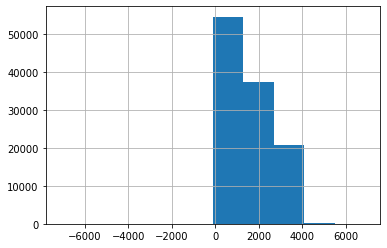

In [62]:
df['n_dias_ate_arquivamento'].hist()

In [63]:
df['data_primeira_sentenca_ok'] = df['data_primeira_sentenca'].apply(fix_data)

In [64]:
df['data_primeira_sentenca_ok'].isnull().sum(), df['data_primeira_sentenca_ok'].notnull().sum()

(622285, 315336)

In [65]:
df['data_primeira_sentenca_ok'] = pd.to_datetime(df['data_primeira_sentenca_ok'] , yearfirst=True, dayfirst=False, infer_datetime_format=True)

In [66]:
df['n_dias_ate_sentenca'] = df['data_primeira_sentenca_ok'] - df['data_ajuizamento_ok']

In [67]:
df['n_dias_ate_sentenca'] = df['n_dias_ate_sentenca'].apply(lambda x: x.days)

In [68]:
df['n_dias_ate_sentenca'].value_counts(dropna=False)

 NaN       622315
 0.0         3268
 1.0         2022
 35.0        1874
 70.0        1702
            ...  
 3906.0         1
-1577.0         1
 3953.0         1
 3954.0         1
-2140.0         1
Name: n_dias_ate_sentenca, Length: 3928, dtype: int64

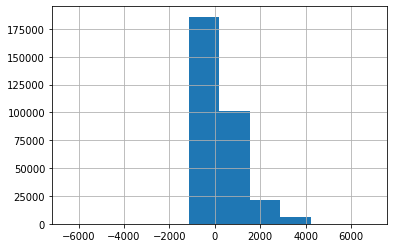

In [69]:
df['n_dias_ate_sentenca'].hist()

In [70]:
df['n_dias_ate_sentenca'].describe()

count    315306.000000
mean        451.525905
std         700.832338
min       -6495.000000
25%          65.000000
50%         146.000000
75%         477.000000
max        6906.000000
Name: n_dias_ate_sentenca, dtype: float64

In [71]:
df[df['n_dias_ate_sentenca'] >= 0].shape, df[df['n_dias_ate_sentenca'] < 0].shape

((315282, 32), (24, 32))

In [72]:
# Exemplo: processo 00040060220018070016 - [rpcessp de ]

In [73]:
df['data_ajuizamento_temp'] = df['dadosBasicos.dataAjuizamento'].apply(fix_data)

In [74]:
df['data_ajuizamento_temp'] = pd.to_datetime(df['data_ajuizamento_temp'] , yearfirst=True, dayfirst=False, infer_datetime_format=True)



In [75]:
def problema_data_ajuizamento(row):
    if row.n_dias_ate_sentenca < 0:
        return 1
    if row.data_ajuizamento_temp > row.data_ajuizamento_ok: #data_ajuizamento_ok é composto pela data da primeira movimentacao
        return 1
    return 0

In [76]:
df['problema_na_data_ajuizamento'] = df.apply(problema_data_ajuizamento, axis=1)

In [77]:
df['problema_na_data_ajuizamento'].value_counts()

0    927422
1     10199
Name: problema_na_data_ajuizamento, dtype: int64

In [ ]:
df.drop('data_ajuizamento_temp', axis=1, inplace=True)

In [82]:
classes = pd.read_csv('data/sgt_classes.csv', sep=';')
assuntos = pd.read_csv('data/sgt_assuntos.csv', sep=';')

dict_assuntos_pais = {}
for _, row in assuntos.iterrows():
    dict_assuntos_pais[row.codigo] = row.cod_pai
    
dict_assuntos = {}
dict_classes = {}

for _, row in assuntos.iterrows():
    dict_assuntos[row.codigo] = row.descricao
    
for _, row in classes.iterrows():
    dict_classes[row.codigo] = row.descricao
    

In [89]:

df['codigo_assunto_pai_1'] = df['codigo_assunto_principal'].map(dict_assuntos_pais)
df['codigo_assunto_pai_2'] = df['codigo_assunto_pai_1'].map(dict_assuntos_pais)
df['codigo_assunto_pai_3'] = df['codigo_assunto_pai_2'].map(dict_assuntos_pais)
df['codigo_assunto_pai_4'] = df['codigo_assunto_pai_3'].map(dict_assuntos_pais)
df['codigo_assunto_pai_5'] = df['codigo_assunto_pai_4'].map(dict_assuntos_pais)
df['assunto_principal'] = df['codigo_assunto_principal'].map(dict_assuntos)
df['assunto_pai_1'] = df['codigo_assunto_pai_1'].map(dict_assuntos)
df['assunto_pai_2'] = df['codigo_assunto_pai_2'].map(dict_assuntos)
df['assunto_pai_3'] = df['codigo_assunto_pai_3'].map(dict_assuntos)
df['assunto_pai_4'] = df['codigo_assunto_pai_4'].map(dict_assuntos)
df['assunto_pai_5'] = df['codigo_assunto_pai_5'].map(dict_assuntos)

In [92]:
df['assunto_pai_4'].value_counts()

DIREITO CIVIL                                                  15852
DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO     2197
DIREITO DA SAÚDE                                                 447
DIREITO PREVIDENCIÁRIO                                            83
DIREITO TRIBUTÁRIO                                                33
Crédito Tributário                                                24
DIREITO DA CRIANÇA E DO ADOLESCENTE                               18
DIREITO PROCESSUAL PENAL                                           9
DIREITO PROCESSUAL CIVIL E DO TRABALHO                             8
DIREITO PENAL                                                      5
Name: assunto_pai_4, dtype: int64

In [93]:
print(df.shape)

(937621, 44)


In [111]:
criminal = [i for i in assuntos.descricao.values if 'crimin' in i.lower()]
criminal += [i for i in assuntos.descricao.values if 'penal' in i.lower()]
criminal += [i for i in assuntos.descricao.values if 'pris' in i.lower()]
criminal += [i for i in assuntos.descricao.values if 'circuns' in i.lower()]
criminal += [i for i in assuntos.descricao.values if 'pena' in i.lower()]
criminal += [i for i in assuntos.descricao.values if 'crime' in i.lower()]
criminal += [i for i in assuntos.descricao.values if 'policia' in i.lower()]
criminal += [i for i in assuntos.descricao.values if 'ato infracional' in i.lower()]
len(criminal), criminal


(227,
 ['Condescendência criminosa',
  'Responsabilidade Criminal por Danos Nucleares',
  'Apologia de Crime ou Criminoso',
  'Discriminação Tributária MERCOSUL',
  'Apologia de Crime ou Criminoso',
  'Condescendência criminosa (art. 320)',
  'Responsabilidade Criminal por Danos Nucleares',
  'Despenalização / Descriminalização',
  'Abolitio Criminis',
  'Por condenação criminal',
  'Abolitio criminis',
  'Apologia de fato criminoso ou do seu autor',
  'Condescendência criminosa',
  'Inelegibilidade - Condenação Criminal por órgão colegiado ou Transitada em Julgado',
  'Não Discriminação',
  'Crimes da Lei que Proíbe Práticas Discriminatórias para Efeitos Trabalhistas',
  'Da Lei que Proíbe Práticas Discriminatórias para Efeitos Trabalhistas',
  'Crimes previstos na Lei da Organização Criminosa',
  'Promoção, constituição, financiamento ou integração de Organização Criminosa',
  'Imputação falsa de prática de infração penal ou revelação inverídica sobre estrutura de organização crimina

In [112]:
print(df.shape)
df = df[~df.assunto_principal.isin(criminal)]
print(df.shape)
for i in range(1,6):
    df = df[~df[f'assunto_pai_{i}'].isin(criminal)]
    print(df.shape)

(925986, 44)
(925979, 44)
(925924, 44)
(925580, 44)
(925568, 44)
(925568, 44)
(925568, 44)


In [118]:
df['assunto_pai_5'].value_counts().tail(10)

DIREITO TRIBUTÁRIO    24
Name: assunto_pai_5, dtype: int64

In [120]:
type(df['assunto_pai_5'].iloc[10])

float

In [142]:
for col in ['codigo_assunto_pai_5', 'codigo_assunto_pai_4', 'codigo_assunto_pai_3', 'codigo_assunto_pai_2', 'codigo_assunto_pai_1', 'codigo_assunto_principal']:
    df[col] = df[col].astype('Int64')

In [193]:
from functools import partial

def get_assunto_nivel_x(row, nivel):
    contador = 0
    for i in ['codigo_assunto_pai_5', 'codigo_assunto_pai_4', 'codigo_assunto_pai_3', 'codigo_assunto_pai_2', 'codigo_assunto_pai_1', 'codigo_assunto_principal']:
        assunto = row[i]
        if type(assunto) != pd._libs.missing.NAType:
            contador += 1
            if contador == nivel:
                #print(i)
                return assunto


nivel_1 = partial(get_assunto_nivel_x, nivel=1)      
nivel_2 = partial(get_assunto_nivel_x, nivel=2)
nivel_3 = partial(get_assunto_nivel_x, nivel=3)
nivel_4 = partial(get_assunto_nivel_x, nivel=4)
nivel_5 = partial(get_assunto_nivel_x, nivel=5)
nivel_6 = partial(get_assunto_nivel_x, nivel=6)

In [195]:
df['codigo_assunto_nivel_1'] = df.apply(nivel_1, axis=1)

In [196]:
df['codigo_assunto_nivel_2'] = df.apply(nivel_2, axis=1)

In [197]:
df['codigo_assunto_nivel_3'] = df.apply(nivel_3, axis=1)

In [198]:
df['codigo_assunto_nivel_4'] = df.apply(nivel_4, axis=1)

In [199]:
df['codigo_assunto_nivel_5'] = df.apply(nivel_5, axis=1)

In [200]:
df['codigo_assunto_nivel_6'] = df.apply(nivel_6, axis=1)

In [204]:
df['assunto_nivel_1'] = df['codigo_assunto_nivel_1'].map(dict_assuntos)
df['assunto_nivel_2'] = df['codigo_assunto_nivel_2'].map(dict_assuntos)
df['assunto_nivel_3'] = df['codigo_assunto_nivel_3'].map(dict_assuntos)
df['assunto_nivel_4'] = df['codigo_assunto_nivel_4'].map(dict_assuntos)
df['assunto_nivel_5'] = df['codigo_assunto_nivel_5'].map(dict_assuntos)
df['assunto_nivel_6'] = df['codigo_assunto_nivel_6'].map(dict_assuntos)

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925568 entries, 0 to 936924
Data columns (total 56 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   siglaTribunal                                   925568 non-null  object        
 1   movimento                                       903730 non-null  object        
 2   grau                                            925568 non-null  object        
 3   dadosBasicos.valorCausa                         597244 non-null  float64       
 4   dadosBasicos.numero                             925568 non-null  object        
 5   dadosBasicos.procEl                             717635 non-null  float64       
 6   dadosBasicos.competencia                        291123 non-null  object        
 7   dadosBasicos.codigoLocalidade                   925568 non-null  object        
 8   dadosBasicos.assunto              

In [214]:
def get_string_assunto(row):
    colunas = ['assunto_nivel_1', 'assunto_nivel_2', 'assunto_nivel_3' ]
    assuntos = []
    
    for col in colunas:
        assunto = row[col]
        if type(assunto) != float:
            assuntos.append(assunto)
            
    return ' --> '.join([i.strip() for i in assuntos])

In [216]:
df['string_assunto_principal_3_niveis'] = df.apply(get_string_assunto, axis=1)

In [217]:
df['string_assunto_principal_3_niveis'].value_counts().head(10)

DIREITO DO TRABALHO --> Rescisão do Contrato de Trabalho --> Verbas Rescisórias                                                  141189
DIREITO CIVIL --> Obrigações --> Espécies de Contratos                                                                            61231
DIREITO CIVIL --> Obrigações --> Espécies de Títulos de Crédito                                                                   36186
DIREITO DO TRABALHO                                                                                                               27642
DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO --> Servidor Público Civil --> Sistema Remuneratório e Benefícios     24314
DIREITO DO TRABALHO --> Responsabilidade Civil do Empregador --> Indenizaçao por Dano Moral                                       19493
DIREITO CIVIL --> Responsabilidade Civil --> Indenização por Dano Moral                                                           18543
DIREITO CIVIL --> Coisas --> Propriedade        

In [218]:
remover = ['codigo_assunto_pai_5', 'codigo_assunto_pai_4', 'codigo_assunto_pai_3', 'codigo_assunto_pai_2', 'codigo_assunto_pai_1', 
 'assunto_pai_5', 'assunto_pai_4', 'assunto_pai_3', 'assunto_pai_2', 'assunto_pai_1']

In [221]:
df.drop(remover, axis=1, inplace=True)

In [224]:
df.assunto_nivel_1.value_counts().tail(10)

DIREITO TRIBUTÁRIO                                             19625
DIREITO ASSISTENCIAL                                            4113
REGISTROS PÚBLICOS                                              3111
DIREITO DA SAÚDE                                                1998
QUESTÕES DE ALTA COMPLEXIDADE, GRANDE IMPACTO E REPERCUSSÃO     1795
DIREITO DA CRIANÇA E DO ADOLESCENTE                              200
DIREITO ELEITORAL                                                177
DIREITO INTERNACIONAL                                            119
DIREITO MARÍTIMO                                                  29
DIREITO ELEITORAL E PROCESSO ELEITORAL DO STF                     10
Name: assunto_nivel_1, dtype: int64

In [222]:
df.head()

,siglaTribunal,movimento,grau,dadosBasicos.valorCausa,dadosBasicos.numero,dadosBasicos.procEl,dadosBasicos.competencia,dadosBasicos.codigoLocalidade,dadosBasicos.assunto,dadosBasicos.dscSistema,dadosBasicos.tamanhoProcesso,dadosBasicos.dataAjuizamento,dadosBasicos.totalAssuntos,dadosBasicos.nivelSigilo,dadosBasicos.classeProcessual,dadosBasicos.orgaoJulgador.nomeOrgao,dadosBasicos.orgaoJulgador.codigoMunicipioIBGE,dadosBasicos.orgaoJulgador.codigoOrgao,dadosBasicos.orgaoJulgador.instancia,ano_ajuizamento,ano_numero,ano_ok,data_primeira_sentenca,codigo_primeira_sentenca,data_arquivamento,codigo_arquivamento,codigo_assunto_principal,data_ajuizamento_ok,data_arquivamento_ok,n_dias_ate_arquivamento,data_primeira_sentenca_ok,n_dias_ate_sentenca,problema_na_data_ajuizamento,assunto_principal,codigo_assunto_nivel_1,codigo_assunto_nivel_2,codigo_assunto_nivel_3,codigo_assunto_nivel_4,codigo_assunto_nivel_5,codigo_assunto_nivel_6,assunto_nivel_1,assunto_nivel_2,assunto_nivel_3,assunto_nivel_4,assunto_nivel_5,assunto_nivel_6,string_assunto_principal_3_niveis
0,TRT4,"[{'identificadorMovimento': '52034597', 'tipoR...",G1,35300.00,00202133320205040020,1.0,NaN,4314902,"[{'principal': True, 'assuntoLocal': None, 'co...",1,NaN,20200318002109,10.0,0,1125,20ª Porto Alegre,4314902,46964,ORIG,2020,2020,2020,SEM MOVIMENTO,-1,SEM MOVIMENTO,-1,10655,2020-03-18,NaT,NaN,NaT,NaN,0,Honorários Advocatícios,8826.0,8842.0,8874.0,10655.0,NaN,NaN,DIREITO PROCESSUAL CIVIL E DO TRABALHO,Partes e Procuradores,Sucumbência,Honorários Advocatícios,NaN,NaN,DIREITO PROCESSUAL CIVIL E DO TRABALHO --> Par...
1,TRT4,"[{'identificadorMovimento': '52036527', 'tipoR...",G1,97000.00,00202875720205040030,1.0,NaN,4314902,"[{'principal': False, 'assuntoLocal': None, 'c...",1,NaN,20200318002308,8.0,0,985,30ª Porto Alegre,4314902,46974,ORIG,2020,2020,2020,SEM MOVIMENTO,-1,SEM MOVIMENTO,-1,2569,2020-03-18,NaT,NaN,NaT,NaN,0,Acidente de Trabalho,864.0,2567.0,1855.0,2569.0,NaN,NaN,DIREITO DO TRABALHO,Responsabilidade Civil do Empregador,Indenizaçao por Dano Moral,Acidente de Trabalho,NaN,NaN,DIREITO DO TRABALHO --> Responsabilidade Civil...
2,TRT4,"[{'identificadorMovimento': '52041238', 'tipoR...",G1,14244.46,00202360920205040204,1.0,NaN,4304606,"[{'principal': False, 'assuntoLocal': None, 'c...",1,NaN,20200318010510,5.0,0,985,4ª Canoas,4304606,46894,ORIG,2020,2020,2020,SEM MOVIMENTO,-1,SEM MOVIMENTO,-1,6065,2020-03-18,NaT,NaN,NaT,NaN,0,Hora Extra,14.0,6031.0,6048.0,6065.0,NaN,NaN,DIREITO TRIBUTÁRIO,Contribuições,Contribuições Previdenciárias,Hora Extra,NaN,NaN,DIREITO TRIBUTÁRIO --> Contribuições --> Contr...
3,TRT4,"[{'identificadorMovimento': '52041704', 'tipoR...",G1,10000.00,00201675020205040406,1.0,NaN,4305108,"[{'principal': True, 'codigoNacional': 9163}]",1,NaN,20200318081723,1.0,0,37,6ª Caxias do Sul,4305108,46902,ORIG,2020,2020,2020,SEM MOVIMENTO,-1,SEM MOVIMENTO,-1,9163,2020-03-18,NaT,NaN,NaT,NaN,0,Penhora / Depósito/ Avaliação,8826.0,9148.0,9163.0,NaN,NaN,NaN,DIREITO PROCESSUAL CIVIL E DO TRABALHO,Liquidação / Cumprimento / Execução,Penhora / Depósito/ Avaliação,NaN,NaN,NaN,DIREITO PROCESSUAL CIVIL E DO TRABALHO --> Liq...
4,TRT4,"[{'identificadorMovimento': '52041887', 'tipoR...",G1,15000.00,00201019320205040851,1.0,NaN,4317103,"[{'principal': True, 'assuntoLocal': None, 'co...",1,NaN,20200318083036,2.0,0,193,VT Santana do Livramento,4317103,46985,ORIG,2020,2020,2020,SEM MOVIMENTO,-1,SEM MOVIMENTO,-1,10254,2020-03-18,NaT,NaN,NaT,NaN,0,Aposentadoria,9985.0,10219.0,10254.0,NaN,NaN,NaN,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DI...,Servidor Público Civil,Aposentadoria,NaN,NaN,NaN,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DI...


In [225]:
df.to_csv('base_trabalho_comum.csv.zip', index=False, compression='zip')

In [6]:
df = pd.read_csv('base_trabalho_comum.csv.zip', compression='zip')

/data/venv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,7,17,28,44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
columns_to_keep =[
    'siglaTribunal',
    'grau',
    'n_dias_ate_sentenca',
    'assunto_principal',
    'assunto_nivel_1',
    'assunto_nivel_2',
    'assunto_nivel_3',
    'dadosBasicos.orgaoJulgador.nomeOrgao',
    'data_ajuizamento_ok','data_primeira_sentenca_ok',
    'dadosBasicos.orgaoJulgador.codigoOrgao',
    'dadosBasicos.numero',
    'dadosBasicos.orgaoJulgador.codigoMunicipioIBGE'
]

In [16]:
df_producao = df[columns_to_keep].copy()

In [17]:
import pickle

def fix_codigo_orgao(valor):
    try:
        return int(valor)
    except:
        return -1
    
df.dropna(subset=['dadosBasicos.orgaoJulgador.codigoOrgao'], inplace=True)
df['dadosBasicos.orgaoJulgador.codigoMunicipioIBGE'] = df['dadosBasicos.orgaoJulgador.codigoMunicipioIBGE'].astype(int)
with open('data/otc.pickle', 'rb') as f:
    otc = pickle.load(f)
with open('data/otn.pickle', 'rb') as f:
    otn = pickle.load(f)

df['dadosBasicos.orgaoJulgador.codigoOrgao'] = df['dadosBasicos.orgaoJulgador.codigoOrgao'].apply(fix_codigo_orgao)

df = df[df['dadosBasicos.orgaoJulgador.codigoOrgao'] != -1]

df['dadosBasicos.orgaoJulgador.codigoMunicipioIBGE'] = df['dadosBasicos.orgaoJulgador.codigoOrgao'].replace(otc)
df['dadosBasicos.orgaoJulgador.nomeOrgao'] = df['dadosBasicos.orgaoJulgador.codigoOrgao'].replace(otn)

In [18]:
df_producao.to_csv('df_producao.csv', index=False)